# Setup - Load an API Token and Libraries

In [38]:
import os
from dotenv import load_dotenv

platform_domain = "https://staging.eodatahub.org.uk"
workspace = "apalmer-tpzuk"
load_dotenv("demo.env")
token = os.getenv("API_TOKEN")
workspaces_bucket = "workspaces-eodhp-staging"

In [10]:
!pip install pystac-client xarray rasterio

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached certifi-2025.1.31-py3-none-any.whl.metadata (2.5 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl.metadata (6.4 kB)
  Using cached jsonschema-4.23.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached charset_normalizer-3.4.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (35 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached jsonschema_specifications-2024.10.1-py3-none-any.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 1.2 MB/s eta 0:00:0000:0100:01
Using cached click-8.1.8-py3-none-any.w

# Create a pystac-client Client for the EODH Catalogue

In [14]:
from pystac_client import Client

# Set resource catalogue top-level url
rc_url = f"{platform_domain}/api/catalogue/stac/catalogs/commercial/catalogs/planet"

# We can also view the STAC Catalogue using STAC Browser here 
# https://staging.eodatahub.org.uk/static-apps/stac-browser/main/index.html#/external/staging.eodatahub.org.uk/api/catalogue/stac/

# Create STAC client
stac_client = Client.open(rc_url, headers={"Authorization": f"Bearer {token}"})

# Search for Planet Data

In [15]:
geom = {
    "type": "Polygon",
    "coordinates": [
        [
            [9.6, 57.1],
            [9.6, 57.0],
            [9.8, 56.9],
            [9.8, 57.0],
            [9.6, 57.1],
        ]
    ],
}
search = stac_client.search(
    max_items=10,
    collections=['PSScene'],
    intersects=geom,
)
for item in search.items():
    print(item.get_self_href())

https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/commercial/catalogs/planet/collections/PSScene/items/20250324_104605_21_24e5
https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/commercial/catalogs/planet/collections/PSScene/items/20250323_105627_18_251e
https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/commercial/catalogs/planet/collections/PSScene/items/20250324_101052_05_2417
https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/commercial/catalogs/planet/collections/PSScene/items/20250325_105223_39_24dc
https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/commercial/catalogs/planet/collections/PSScene/items/20250324_101055_57_2417
https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/commercial/catalogs/planet/collections/PSScene/items/20250325_105225_63_24dc
https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/commercial/catalogs/planet/collections/PSScene/items/20250324_104602_97_24e5
https://staging.eodatahub.org.uk/a

# Obtain a Quote for Planet Data

In [23]:
import requests

item_href = "https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/commercial/catalogs/planet/collections/PSScene/items/20250217_101155_07_24c7"
url = f"{item_href}/quote"
headers = {
    'accept': 'application/json', 
    'Content-Type': 'application/json', 
    'Authorization': f'Bearer {token}'
}
data =  {
    "coordinates": [
        [
            [9.6, 57.1],
            [9.6, 57.0],
            [9.8, 56.9],
            [9.8, 57.0],
            [9.6, 57.1]
        ]
    ]
}

response = requests.post(url, headers=headers, json=data)

print("Status Code", response.status_code)
print("Response ", response.json())

Status Code 200
Response  {'value': 136.0, 'units': 'km2'}


# Order Planet Data

In [25]:
import requests

item_href = "https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/commercial/catalogs/planet/collections/PSScene/items/20250217_101155_07_24c7"
url = f"{item_href}/order"
headers = {
    'accept': 'application/json', 
    'Content-Type': 'application/json', 
    'Authorization': f'Bearer {token}'
}
data =  {
    "productBundle": "General use",
    "coordinates": [
        [
            [9.6, 57.1],
            [9.6, 57.0],
            [9.8, 56.9],
            [9.8, 57.0],
            [9.6, 57.1]
        ]
    ]
}

response = requests.post(url, headers=headers, json=data)

print("Status Code", response.status_code)
print("Response ", response.json())

location_header = response.headers.get('Location')
print(location_header)

Status Code 201
Response  {'bbox': [9.397758303198756, 56.89142503519928, 9.943073820663766, 57.11533518004268], 'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[9.475656554969843, 57.11533518004268], [9.397758303198756, 56.96362143025387], [9.863019362505952, 56.89142503519928], [9.943073820663766, 57.04324504369015], [9.475656554969843, 57.11533518004268]]]}, 'properties': {'title': None, 'description': None, 'datetime': '2025-02-17T10:11:55.072436Z', 'created': '2025-03-25T16:13:59.609157Z', 'updated': '2025-03-25T16:13:59.609157Z', 'start_datetime': None, 'end_datetime': None, 'license': None, 'providers': None, 'platform': None, 'instruments': None, 'constellation': None, 'mission': None, 'gsd': 3.3, 'acquired': '2025-02-17T10:11:55.072436Z', 'anomalous_pixels': 0, 'clear_confidence_percent': 76, 'clear_percent': 76, 'cloud_cover': 0, 'cloud_percent': 0, 'ground_control': True, 'heavy_haze_percent': 0, 'instrument': 'PSB.SD', 'item_type': 'PSScene', 'light_haze

# Read STAC for Ordered Planet Data

In [30]:
from pystac import Item
from pystac_client import CollectionClient

data_i_ordered_earlier = "https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/user/catalogs/apalmer-tpzuk/catalogs/commercial-data/catalogs/planet"
stac_client = Client.open(data_i_ordered_earlier, headers={"Authorization": f"Bearer {token}"})

In [31]:
ordered_item = next(stac_client.get_items("20250217_101155_07_24c7"))
ordered_item

<Item id=20250217_101155_07_24c7>

In [32]:
asset = ordered_item.get_assets()["20250217_101155_07_24c7_3B_AnalyticMS_clip.tif"]
asset

<Asset href=https://apalmer-tpzuk.staging.eodatahub-workspaces.org.uk/files/workspaces-eodhp-staging/commercial-data/planet/PSScene/20250217_101155_07_24c7_3B_AnalyticMS_clip.tif>

# Fetch Ordered Planet Data

In [88]:
import urllib3
from io import BytesIO

resp = urllib3.request("GET", asset.href, headers={"Authorization": f"Bearer {token}"})
resp.data[0:100]

b'II*\x00D2\xa3\x05\x14\x00\x00\x01\x03\x00\x01\x00\x00\x00\x1f\x10\x00\x00\x01\x01\x03\x00\x01\x00\x00\x00\xd5\x1c\x00\x00\x02\x01\x03\x00\x04\x00\x00\x00\xfe\x00\x00\x00\x03\x01\x03\x00\x01\x00\x00\x00\x05\x00\x00\x00\x06\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00\x15\x01\x03\x00\x01\x00\x00\x00\x04\x00\x00\x00\x1c\x01\x03\x00\x01\x00\x00\x00\x02\x00\x00\x00=\x01\x03\x00\x01\x00'

# Plot Planet Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.1359].


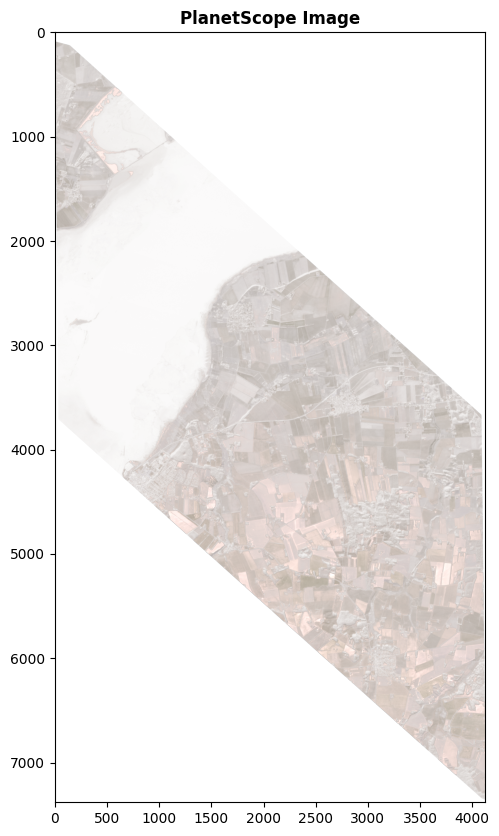

In [89]:
from rasterio.plot import show
import rasterio

with rasterio.open(BytesIO(resp.data)) as src:
    f = src.read()
    fig, ax = plt.subplots(figsize=(10, 10))
    show(f / 10000, ax=ax, title="PlanetScope Image")
    plt.show()

# Further Visualisation of Planet Data

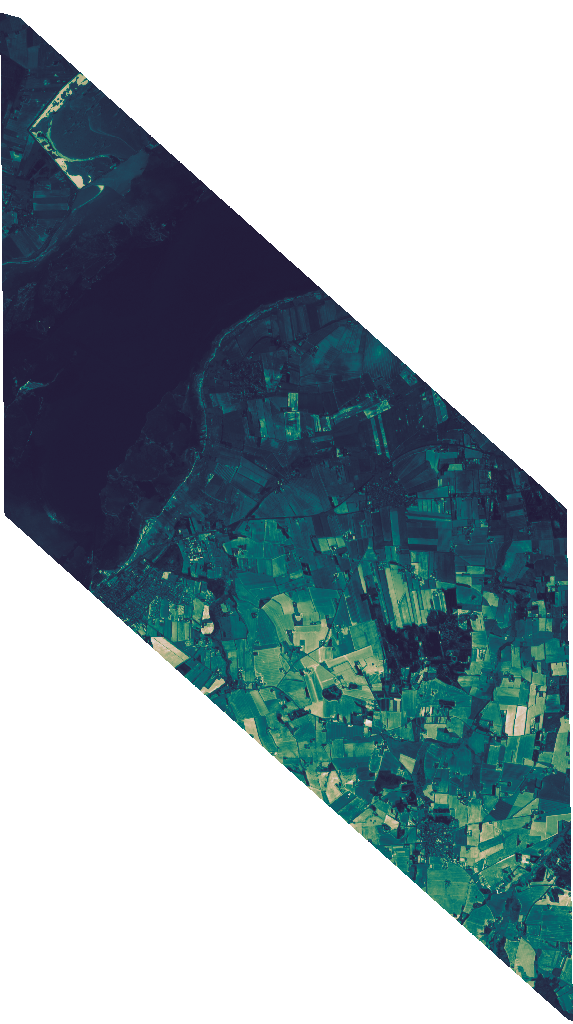

In [ ]:
import requests
from IPython.display import Image, display

TITILER_PREVIEW_URL = f'https://staging.eodatahub.org.uk/titiler/core/cog/preview'
TITILER_PREVIEW_PARAMS = {
    'url': asset.href,
    'bidx': 1,
    'rescale': '2229,12331',
    'colormap_name': 'rain_r'
}

response = requests.get(TITILER_PREVIEW_URL, params=TITILER_PREVIEW_PARAMS, headers={'Authorization': f'Bearer {token}'})

# Display the image
image = Image(response.content)
display(image)

# Obtain a Quote for Airbus SAR Data

In [28]:
import requests

item_href = "https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/commercial/catalogs/airbus/collections/airbus_sar_data/items/TSX-1_WS_S_wide_001R_97985_D33003943_29000"
url = f"{item_href}/quote"
headers = {
    'accept': 'application/json', 
    'Content-Type': 'application/json', 
    'Authorization': f'Bearer {token}'
}
data =  {
    "licence": "Single User Licence",
}

response = requests.post(url, headers=headers, json=data)

print("Status Code", response.status_code)
print("Response ", response.json())

Status Code 200
Response  {'value': 906.5, 'units': 'EUR'}


# Order Airbus SAR Data

In [ ]:
import requests

item_href = "https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/commercial/catalogs/airbus/collections/airbus_sar_data/items/TSX-1_WS_S_wide_001R_97985_D33003943_29000"
url = f"{item_href}/order"
headers = {
    "accept": "application/json", 
    "Content-Type": "application/json", 
    "Authorization": f"Bearer {token}"
}
data =  {
    "licence": "Single User Licence",
    "productBundle": "SSC",
    "radarOptions": {
        "orbit": "rapid"
    }
}

response = requests.post(url, headers=headers, json=data)

print("Status Code", response.status_code)
print("Response ", response.json())

Commercial data can also be ordered through the pyeodh Python client for EO Data Hub

In [97]:
# client.get_catalog_service().get_catalog(
#     "supported-datasets/catalogs/airbus"
# ).get_collection("airbus_sar_data").get_items()[0].commercial_data_order(
#     product_bundle="general_use"
# )

# Obtain a Quote for Airbus Optical Data

In [33]:
import requests

item_href = "https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/commercial/catalogs/airbus/collections/airbus_phr_data/items/DS_PHR1A_201203021558128_FR1_PX_W080S03_0221_01728"
url = f"{item_href}/quote"
headers = {
    'accept': 'application/json', 
    'Content-Type': 'application/json', 
    'Authorization': f'Bearer {token}'
}
data =  {
    "licence": "Standard",
    "coordinates": [
        [
            [-79.8,-2.1], 
            [-79.8,-2.2], 
            [-79.95,-2.2], 
            [-79.95,-2.1], 
            [-79.8,-2.1]
        ]
    ]
}

response = requests.post(url, headers=headers, json=data)

print("Status Code", response.status_code)
print("Response ", response.json())

Status Code 200
Response  {'value': 1472.0, 'units': 'EUR'}


# Order Airbus Optical Data

In [37]:
import requests

item_href = "https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/catalogs/airbus/collections/airbus_phr_data/items/DS_PHR1A_201203021558128_FR1_PX_W080S03_0221_01728"
url = f"{item_href}/order"
headers = {
    'accept': 'application/json', 
    'Content-Type': 'application/json', 
    'Authorization': f'Bearer {token}'
}
data =  {
    "licence": "Standard",
    "endUserCountry": "GB",
    "productBundle": "General use", 
    "coordinates": [
        [
            [-79.8,-2.1], 
            [-79.8,-2.2], 
            [-79.95,-2.2], 
            [-79.95,-2.1], 
            [-79.8,-2.1]
        ]
    ]
}

response = requests.post(url, headers=headers, json=data)

print("Status Code", response.status_code)
print("Response ", response.json())

Status Code 201
Response  {'type': 'Feature', 'stac_version': '1.0.0', 'stac_extensions': ['https://stac-extensions.github.io/eo/v2.0.0/schema.json', 'https://stac-extensions.github.io/sat/v1.0.0/schema.json', 'https://stac-extensions.github.io/view/v1.0.0/schema.json', 'https://stac-extensions.github.io/order/v1.1.0/schema.json'], 'id': 'DS_PHR1A_201203021558128_FR1_PX_W080S03_0221_01728', 'collection': 'airbus_phr_data', 'geometry': {'type': 'Polygon', 'coordinates': [[[-79.9865530931312, -2.05530453999506], [-79.9870167957042, -2.24003371246317], [-79.9326765695082, -2.24260917869352], [-79.7810137106216, -2.25197431130979], [-79.7812923802786, -2.06521867471582], [-79.8463962663722, -2.0614543312179], [-79.9865530931312, -2.05530453999506]]]}, 'bbox': [-79.9870167957042, -2.25197431130979, -79.7810137106216, -2.05530453999506], 'properties': {'title': '', 'datetime': '2012-03-02T15:58:12.806000Z', 'updated': '2025-03-25T16:29:05.901513Z', 'platform': 'PHR1A', 'constellation': 'PHR'